In [1]:
#Figure 5 graph plotting 
#v1.0 version, this is the first consolidation of analysis done so far
#Requires the environment packages found in 23pubenv

In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
import random as rand
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.api as sm

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path.cwd().parent / 'Data Sets/2023_01_24_main-set'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(79)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))


In [4]:
#So track IDs and corrresponding tracks are found in tracking df, 
#The corresponding points that made the circle are in arcos df, 
#the waves to analze are in waves df, need to go from 
#WaveDF --> arcosDF --> trackingDF 
#Get centroid and radius over time from waveDF, 
#Get trackID inside wavefront from arcosDF, 
#Get track from tracking, then calc radial movement as enter wavefront? 

#Calc a stable centroid: 
#Only looking at clID that hvae waves mapped to them for now...

clIDs = wave_df.clTrackID.values

wave_ex = wave_df[wave_df.clTrackID == clIDs[0]]
arcos_ex =  arcos_df[arcos_df.clTrackID == clIDs[0]]

centroids = np.stack(wave_ex.wave_centroid.values, axis=0)
mean_centroid = (np.mean(centroids[:,0]), np.mean(centroids[:,1]))

#get the tracks that arcos says are inside the wave...
track_collect_all = []

tracks = tracking_df.groupby('track_id')

for i, track in tqdm(tracks): 
    if i in arcos_ex.track_id.unique():
        track_collect_all.append(track)

tracks_in_ex_wave = pd.concat(track_collect_all, ignore_index=True)


#get the tracks that arcos says are inside the wave...
track_collect_all_in_any_wave = []

tracks = tracking_df.groupby('track_id')

for i, track in tqdm(tracks): 
    if i in arcos_df.track_id.unique():
        track['length'] = len(track)
        track_collect_all_in_any_wave.append(track)

tracks_in_all_arcos = pd.concat(track_collect_all_in_any_wave, ignore_index=True)
print('There are {} tracks across all arcos events...'.format(str(len(tracks_in_all_arcos.track_id.unique()))))

arcos_whole_duration_track_collect = []
min_track_duration = 36 #3min

for tid, track in tracks_in_all_arcos.groupby('track_id'):
    if len(track) > min_track_duration:
        #Get the time, x, and y points, but DO NOT SMOOTH here. 
        #Smoothing for this aligned measurement brings forward the movement in time 
        #This confuses what we are getting at here, so do not smooth in time.
        time = track.timepoint.values*5.0

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(track.x.values), np.array(track.y.values)), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
        inst_radial_step = [dist_from_center[i+1] - dist_from_center[i] for i in range(len(dist_from_center)-1)]
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Integrate calcium signal over mean?
        int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['inst_radial_movement'] = np.insert(inst_radial_step, 0, float('nan'), axis=0)
        track['max_radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        arcos_whole_duration_track_collect.append(track)

arcos_duration_tracks_DF = pd.concat(arcos_whole_duration_track_collect, ignore_index=True)

wave_start_times = []

for wid, wave_event in wave_df.groupby('clTrackID'):
    wave_start_times.append(wave_event.timepoint.min())

    
swarm_start = min(wave_start_times)
radial_movement_integration = 0.0

coll_timepoints = []
radial_collection = []
start_integration_t = 60 #Cut off 5min at start of video to eliminate drift as cells settle into frame

for t, time_slice in arcos_duration_tracks_DF.groupby('timepoint'):
    if t > start_integration_t:
        radial_movement_integration -= np.nansum(time_slice.inst_radial_movement.values)
        coll_timepoints.append((5.0/60.0)*(t - swarm_start))
        radial_collection.append(radial_movement_integration)

#Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:

event_sizes = []
event_start_stops = []
event_areas = []

for clID, clEvent in wave_df.groupby('clTrackID'):

    event_start_stops.append((np.min(clEvent.timepoint.values), np.max(clEvent.timepoint.values)))
    event_areas.append(np.pi*(clEvent.circle_radius.max()**2))
    event_sizes.append(clEvent.circle_radius.max())




100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 36147/36147 [00:11<00:00, 3097.19it/s]


There are 5813 tracks across all arcos events...


In [5]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

Text(0, 0.5, '')

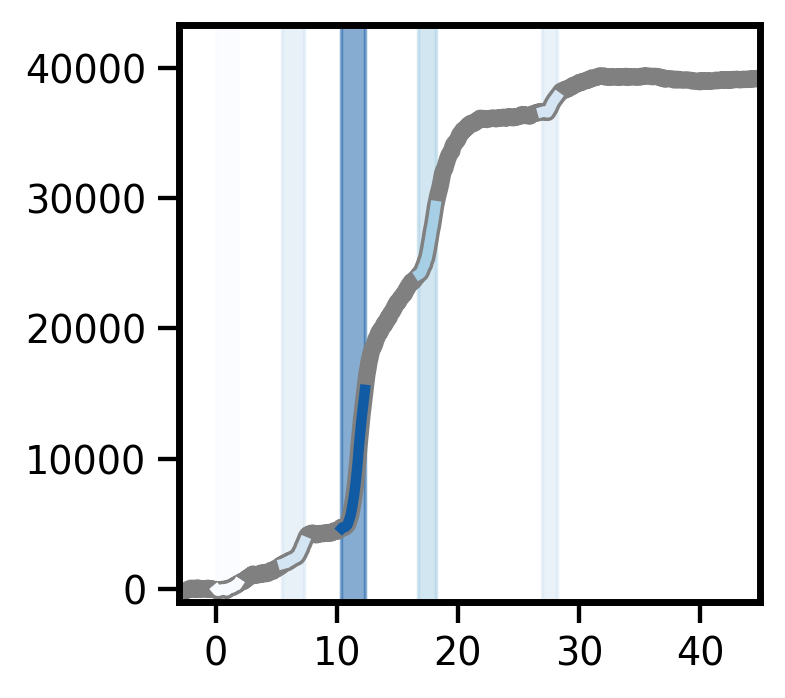

In [6]:
norma = plt.Normalize(25000, 300000)
#palette = LinearSegmentedColormap.from_list('what', ['#4B4B4B', '#DBD08F','#BC2313'])
palette = sns.color_palette("Blues",as_cmap=True)
colors = [palette(norma(size)) for size in event_areas]

fig, ax1 = plt.subplots(figsize=(3,3), dpi=250)
ax1.plot(coll_timepoints,radial_collection, 'grey', linewidth=5)

y_scale = max(radial_collection) * 1.1

for clID, clr, strstp in zip(clIDs, colors, event_start_stops):
    rel_time = np.array(coll_timepoints[strstp[0]:strstp[1]])-(5.0/60.0)*start_integration_t
    rel_rad_coll = np.array(radial_collection[strstp[0]- start_integration_t: strstp[1]- start_integration_t])
    ax1.plot(rel_time,rel_rad_coll, color=clr, linewidth=3)
    ax1.fill_betweenx([-1000,y_scale], (5.0/60.0)*(strstp[0] - swarm_start), (5.0/60.0)*(strstp[1] - swarm_start), alpha=0.5, color=clr)


#plt.vlines(wave_start_times_real, ymin=-2, ymax=40000, linestyles='--', colors='grey')
plt.xlim(-3,45)
plt.ylim(-1000,y_scale)
#plt.colorbar(cm.ScalarMappable(norm=norma, cmap=palette))
plt.xlabel('')
plt.ylabel('')
#plt.savefig('fig5-79-accumulation-radial-movement-v-time-w-wave-area-highlight.png', dpi=300, bbox_inches='tight')

In [25]:
coll_timepoints[strstp[0]:strstp[1]]

[18.916666666666664,
 19.0,
 19.083333333333332,
 19.166666666666664,
 19.25,
 19.333333333333332,
 19.416666666666664,
 19.5,
 19.583333333333332]

In [52]:

#Lets import an arcos set, wave data, and the corresponding tracking data...
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

img_numbers = []
density_collect = []
integrated_movements = []
max_rs = []
number_waves = []
area_sums = []

for image in tqdm(list(images_folder.glob('*.tif'))):
    
    image_num = image.stem
    
    if image_num[0] == '.':
        continue

    wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
    arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
    tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))

    #So track IDs and corrresponding tracks are found in tracking df, 
    #The corresponding points that made the circle are in arcos df, 
    #the waves to analze are in waves df, need to go from 
    #WaveDF --> arcosDF --> trackingDF 
    #Get centroid and radius over time from waveDF, 
    #Get trackID inside wavefront from arcosDF, 
    #Get track from tracking, then calc radial movement as enter wavefront? 

    #Calc a stable centroid: 
    #Only looking at clID that hvae waves mapped to them for now...

    clIDs = wave_df.clTrackID.values

    wave_ex = wave_df[wave_df.clTrackID == clIDs[0]]
    arcos_ex =  arcos_df[arcos_df.clTrackID == clIDs[0]]

    centroids = np.stack(wave_ex.wave_centroid.values, axis=0)
    mean_centroid = (np.mean(centroids[:,0]), np.mean(centroids[:,1]))

    #get the tracks that arcos says are inside the wave...
    track_collect_all = []

    tracks = tracking_df.groupby('track_id')

    for i, track in tracks: 
        if i in arcos_ex.track_id.unique():
            track_collect_all.append(track)

    tracks_in_ex_wave = pd.concat(track_collect_all, ignore_index=True)


    #get the tracks that arcos says are inside the wave...
    track_collect_all_in_any_wave = []

    tracks = tracking_df.groupby('track_id')

    for i, track in tracks: 
        if i in arcos_df.track_id.unique():
            track['length'] = len(track)
            track_collect_all_in_any_wave.append(track)

    tracks_in_all_arcos = pd.concat(track_collect_all_in_any_wave, ignore_index=True)
    print('There are {} tracks across all arcos events...'.format(str(len(tracks_in_all_arcos.track_id.unique()))))

    arcos_whole_duration_track_collect = []
    min_track_duration = 36 #3min

    for tid, track in tracks_in_all_arcos.groupby('track_id'):
        if len(track) > min_track_duration:
            #Get the time, x, and y points, but DO NOT SMOOTH here. 
            #Smoothing for this aligned measurement brings forward the movement in time 
            #This confuses what we are getting at here, so do not smooth in time.
            time = track.timepoint.values*5.0

            #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
            coords = np.stack((np.array(track.x.values), np.array(track.y.values)), axis=1)
            lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
            radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
            dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
            inst_radial_step = [dist_from_center[i+1] - dist_from_center[i] for i in range(len(dist_from_center)-1)]
            velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
            angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
            cis = np.cos(angles)
            radial_velocity = velocity*cis

            #Integrate calcium signal over mean?
            int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())

            #Append the relevant parameters to the track: 
            track['radial_dist'] = dist_from_center
            track['inst_radial_movement'] = np.insert(inst_radial_step, 0, float('nan'), axis=0)
            track['max_radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
            track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
            track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
            track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
            arcos_whole_duration_track_collect.append(track)

    arcos_duration_tracks_DF = pd.concat(arcos_whole_duration_track_collect, ignore_index=True)

    wave_start_times = []

    for wid, wave_event in wave_df.groupby('clTrackID'):
        wave_start_times.append(wave_event.timepoint.min())

    radial_movement_integration = 0.0

    coll_timepoints = []
    radial_collection = []

    for t, time_slice in arcos_duration_tracks_DF.groupby('timepoint'):
        radial_movement_integration -= np.nansum(time_slice.inst_radial_movement.values)
        coll_timepoints.append((5.0/60.0)*(t - min(wave_start_times)))
        radial_collection.append(radial_movement_integration)

    #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:

    event_sizes = []
    event_start_stops = []
    event_areas = []

    for clID, clEvent in wave_df.groupby('clTrackID'):

        event_start_stops.append((np.min(clEvent.timepoint.values), np.max(clEvent.timepoint.values)))
        event_areas.append(np.pi*(clEvent.circle_radius.max()**2))
        event_sizes.append(clEvent.circle_radius.max())

    '''
    norma = plt.Normalize(50, 400)
    #palette = LinearSegmentedColormap.from_list('what', ['#4B4B4B', '#DBD08F','#BC2313'])
    palette = sns.color_palette("Blues",as_cmap=True)
    colors = [palette(norma(r_size)) for r_size in event_sizes]

    fig, ax1 = plt.subplots(figsize=(4,4), dpi=250)
    ax1.plot(coll_timepoints,radial_collection, 'grey', linewidth=5)

    y_scale = max(radial_collection) * 1.1

    for clID, clr, strstp in zip(clIDs, colors, event_start_stops):
        plt.plot(coll_timepoints[strstp[0]:strstp[1]],radial_collection[strstp[0]:strstp[1]], color=clr, linewidth=3)
        plt.fill_betweenx([-1000,y_scale], (5.0/60.0)*(strstp[0] - min(wave_start_times)), (5.0/60.0)*(strstp[1] - min(wave_start_times)), alpha=0.25, color=clr)


    #plt.vlines(wave_start_times_real, ymin=-2, ymax=40000, linestyles='--', colors='grey')
    plt.xlim(-5,35)
    plt.ylim(-1000,y_scale)
    plt.colorbar(cm.ScalarMappable(norm=norma, cmap=palette))
    plt.xlabel('Time')
    plt.ylabel('Integrated Radial Movement (um)')
    save_path = '/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/integrated_radial_move/'
    plt.savefig(save_path + image_num + '-rad-int.png',facecolor='white', bbox_inches='tight', dpi=150)
    '''
    img_numbers.append(int(image_num))
    density_collect.append(arcos_df.cell_density[0])
    integrated_movements.append(radial_collection[-1])
    max_rs.append(max(event_sizes))
    number_waves.append(len(event_sizes))
    area_sums.append(sum(event_areas))

  0%|                                                    | 0/58 [00:00<?, ?it/s]

There are 4035 tracks across all arcos events...


  2%|▊                                           | 1/58 [00:46<43:47, 46.09s/it]

There are 6814 tracks across all arcos events...


  3%|█▌                                          | 2/58 [01:46<51:03, 54.70s/it]

There are 540 tracks across all arcos events...


  7%|███                                         | 4/58 [01:58<21:33, 23.96s/it]

There are 1468 tracks across all arcos events...


  9%|███▊                                        | 5/58 [02:15<19:19, 21.87s/it]

There are 2843 tracks across all arcos events...


 10%|████▌                                       | 6/58 [02:45<21:11, 24.46s/it]

There are 3447 tracks across all arcos events...


 12%|█████▎                                      | 7/58 [03:08<20:15, 23.83s/it]

There are 3204 tracks across all arcos events...


 14%|██████                                      | 8/58 [03:32<19:57, 23.95s/it]

There are 2891 tracks across all arcos events...


 16%|██████▊                                     | 9/58 [04:05<21:43, 26.61s/it]

There are 3941 tracks across all arcos events...


 17%|███████▍                                   | 10/58 [04:36<22:31, 28.15s/it]

There are 3690 tracks across all arcos events...


 19%|████████▏                                  | 11/58 [05:15<24:37, 31.43s/it]

There are 3669 tracks across all arcos events...


 21%|████████▉                                  | 12/58 [05:51<25:04, 32.71s/it]

There are 5807 tracks across all arcos events...


 22%|█████████▋                                 | 13/58 [06:46<29:32, 39.39s/it]

There are 3680 tracks across all arcos events...


 24%|██████████▍                                | 14/58 [07:11<25:48, 35.19s/it]

There are 5148 tracks across all arcos events...


 26%|███████████                                | 15/58 [07:53<26:36, 37.14s/it]

There are 2483 tracks across all arcos events...


 28%|███████████▊                               | 16/58 [08:18<23:21, 33.36s/it]

There are 2047 tracks across all arcos events...


 29%|████████████▌                              | 17/58 [08:41<20:47, 30.42s/it]

There are 4593 tracks across all arcos events...


 31%|█████████████▎                             | 18/58 [10:09<31:46, 47.67s/it]

There are 6001 tracks across all arcos events...


 33%|██████████████                             | 19/58 [11:07<33:01, 50.81s/it]

There are 3458 tracks across all arcos events...


 34%|██████████████▊                            | 20/58 [11:43<29:22, 46.39s/it]

There are 4279 tracks across all arcos events...


 36%|███████████████▌                           | 21/58 [12:21<26:59, 43.76s/it]

There are 6905 tracks across all arcos events...


 38%|████████████████▎                          | 22/58 [13:32<31:12, 52.02s/it]

There are 5572 tracks across all arcos events...


 40%|█████████████████                          | 23/58 [14:10<27:52, 47.80s/it]

There are 2468 tracks across all arcos events...


 41%|█████████████████▊                         | 24/58 [14:40<23:59, 42.34s/it]

There are 1643 tracks across all arcos events...


 43%|██████████████████▌                        | 25/58 [15:03<20:03, 36.47s/it]

There are 5275 tracks across all arcos events...


 45%|███████████████████▎                       | 26/58 [16:14<25:00, 46.88s/it]

There are 5813 tracks across all arcos events...


 47%|████████████████████                       | 27/58 [17:33<29:13, 56.56s/it]

There are 3192 tracks across all arcos events...


 48%|████████████████████▊                      | 28/58 [18:08<25:01, 50.04s/it]

There are 7847 tracks across all arcos events...


 50%|█████████████████████▌                     | 29/58 [19:20<27:25, 56.73s/it]

There are 2592 tracks across all arcos events...


 52%|██████████████████████▏                    | 30/58 [19:51<22:52, 49.01s/it]

There are 5155 tracks across all arcos events...


 53%|██████████████████████▉                    | 31/58 [21:19<27:22, 60.83s/it]

There are 3545 tracks across all arcos events...


 55%|███████████████████████▋                   | 32/58 [22:13<25:26, 58.69s/it]

There are 3127 tracks across all arcos events...


 57%|████████████████████████▍                  | 33/58 [23:04<23:25, 56.23s/it]

There are 5993 tracks across all arcos events...


 59%|█████████████████████████▏                 | 34/58 [23:59<22:26, 56.11s/it]

There are 3745 tracks across all arcos events...


 60%|█████████████████████████▉                 | 35/58 [24:39<19:39, 51.28s/it]

There are 7789 tracks across all arcos events...


 62%|██████████████████████████▋                | 36/58 [25:33<19:00, 51.83s/it]

There are 4681 tracks across all arcos events...


 64%|███████████████████████████▍               | 37/58 [26:06<16:13, 46.34s/it]

There are 2187 tracks across all arcos events...


 66%|████████████████████████████▏              | 38/58 [26:47<14:52, 44.65s/it]

There are 1293 tracks across all arcos events...


 67%|████████████████████████████▉              | 39/58 [27:03<11:24, 36.05s/it]

There are 3230 tracks across all arcos events...


 69%|█████████████████████████████▋             | 40/58 [27:54<12:08, 40.46s/it]

There are 1004 tracks across all arcos events...


 71%|██████████████████████████████▍            | 41/58 [28:06<09:05, 32.10s/it]

There are 3019 tracks across all arcos events...


 72%|███████████████████████████████▏           | 42/58 [28:48<09:21, 35.11s/it]

There are 3241 tracks across all arcos events...


 74%|███████████████████████████████▉           | 43/58 [29:33<09:27, 37.87s/it]

There are 2047 tracks across all arcos events...


 76%|████████████████████████████████▌          | 44/58 [29:52<07:32, 32.32s/it]

There are 2835 tracks across all arcos events...


 78%|█████████████████████████████████▎         | 45/58 [30:15<06:23, 29.53s/it]

There are 7676 tracks across all arcos events...


 79%|██████████████████████████████████         | 46/58 [31:10<07:25, 37.11s/it]

There are 3545 tracks across all arcos events...


 81%|██████████████████████████████████▊        | 47/58 [32:01<07:35, 41.37s/it]

There are 8960 tracks across all arcos events...


 83%|███████████████████████████████████▌       | 48/58 [33:06<08:03, 48.36s/it]

There are 7117 tracks across all arcos events...


 84%|████████████████████████████████████▎      | 49/58 [33:46<06:52, 45.85s/it]

There are 4903 tracks across all arcos events...


 86%|█████████████████████████████████████      | 50/58 [34:39<06:24, 48.03s/it]

There are 1761 tracks across all arcos events...


 88%|█████████████████████████████████████▊     | 51/58 [35:00<04:39, 39.87s/it]

There are 576 tracks across all arcos events...


 90%|██████████████████████████████████████▌    | 52/58 [35:10<03:06, 31.10s/it]

There are 1747 tracks across all arcos events...


 91%|███████████████████████████████████████▎   | 53/58 [35:26<02:12, 26.47s/it]

There are 965 tracks across all arcos events...


 93%|████████████████████████████████████████   | 54/58 [35:40<01:31, 22.75s/it]

There are 1691 tracks across all arcos events...


 95%|████████████████████████████████████████▊  | 55/58 [35:56<01:01, 20.64s/it]

There are 3297 tracks across all arcos events...


 97%|█████████████████████████████████████████▌ | 56/58 [36:21<00:44, 22.15s/it]

There are 3931 tracks across all arcos events...


 98%|██████████████████████████████████████████▎| 57/58 [37:02<00:27, 27.69s/it]

There are 2152 tracks across all arcos events...


100%|███████████████████████████████████████████| 58/58 [37:28<00:00, 38.77s/it]


In [53]:
#Usually the analysis was run, and the csv imported from the main analysis result for replotting: 
#big_df = pd.DataFrame({'img_num':img_numbers,'density':density_collect,'integrated_move':integrated_movements,'max_r':max_rs,'num_waves':number_waves,'max_areas':area_sums})

#big_df.to_csv('fig5-max-wave-area-v-movement.csv')

In [7]:
#Reload here: 
big_df = pd.read_csv('fig5-max-wave-area-v-movement.csv')

In [8]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

Text(0, 0.5, '')

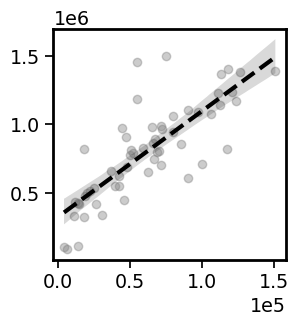

In [9]:
plt.figure(figsize=(3,3))
sns.regplot(data=big_df, y='max_areas', x='integrated_move', scatter_kws={'alpha':0.4, 'color':'grey'}, line_kws={'color':'black', 'linestyle':'--'})
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('')
plt.ylabel('')
#plt.savefig('fig5-max-wave-area-v-movement.png', dpi=300, bbox_inches='tight')

In [11]:
fit_ys_5c = big_df.dropna(axis=0)['max_areas'].values

fit_xs_5c = big_df.dropna(axis=0)['integrated_move'].values
fit_xs_5c = sm.add_constant(fit_xs_5c)
model_5c = sm.OLS(fit_ys_5c,fit_xs_5c)
results_5c = model_5c.fit()
print(results_5c.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     101.1
Date:                Mon, 12 Feb 2024   Prob (F-statistic):           4.58e-14
Time:                        18:33:39   Log-Likelihood:                -779.03
No. Observations:                  57   AIC:                             1562.
Df Residuals:                      55   BIC:                             1566.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.201e+05   5.53e+04      5.791      0.0

In [12]:

meta_df = pd.read_csv(Path(base_path / 'analysis_DF.csv'))

In [13]:
format_df = big_df.rename(columns={'img_num':'File_ID'})

In [14]:
merged_waves_meta_df = pd.merge(meta_df, format_df, on='File_ID')

In [15]:
tag_dfs = []

for filename, group in merged_waves_meta_df.groupby('Original_File'):
    
    file_density = filename.split('mill')[0][-2:]
    
    if file_density == 'if':
        den_bin = 10
    elif file_density == '_3':
        den_bin = 3
    elif file_density == '_6':
        den_bin = 6
    elif file_density == '10':
        den_bin = 10
    
    group['density_bin'] = den_bin
    tag_dfs.append(group)

In [16]:
meta_den_bin_add_DF = pd.concat(tag_dfs, ignore_index=True)

In [17]:
cpal = sns.color_palette('Purples', 8)

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, '')

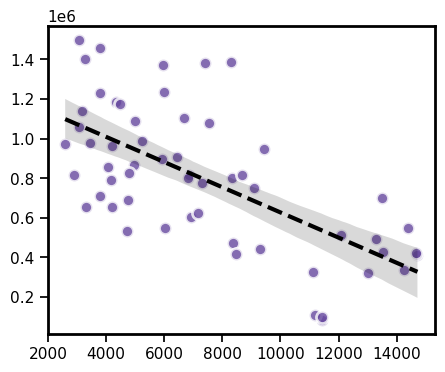

In [18]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})
plt.figure(figsize=(5,4))
sns.scatterplot(data=meta_den_bin_add_DF, x='density', y='max_areas', color=[cpal[6]], s=75, linewidth=2, alpha=0.8, legend=False)
sns.regplot(data=big_df, x='density', y='max_areas', scatter_kws={'alpha':0}, line_kws={'color':'black', 'linestyle':'--'})
plt.xlabel('')
plt.ylabel('')
#plt.savefig('fig5-max-wave-area-v-cell-density.png', dpi=300, bbox_inches='tight')

In [19]:
fit_xs_5d = big_df['density'].values
fit_xs_5d = sm.add_constant(fit_xs_5d)
fit_ys_5d = big_df['max_areas'].values
model_5d = sm.OLS(fit_ys_5d,fit_xs_5d)
results_5d = model_5d.fit()
print(results_5d.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     40.27
Date:                Mon, 12 Feb 2024   Prob (F-statistic):           4.42e-08
Time:                        18:34:15   Log-Likelihood:                -793.10
No. Observations:                  57   AIC:                             1590.
Df Residuals:                      55   BIC:                             1594.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.263e+06   8.16e+04     15.475      0.0

In [20]:
print("target n: {}".format(len(big_df)))
print("volunteer N: {}".format(len(meta_den_bin_add_DF.volunteer_ID.unique())))

target n: 57
volunteer N: 5
